<a href="https://colab.research.google.com/github/KwonYN/TIL/blob/master/PYTHON/TENSORFLOW/Ch3_%EC%98%88%EC%A0%9C_17_MNIST_SLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter3-5. Deep Learning 기초 : Multi Layer Perceptron (MLP)

>## [예제3-17] MNIST Classification : SLP

>### Load modules

In [1]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

print("Module Loaded.")
print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

Module Loaded.
NumPy Version :1.17.4
TensorFlow Version :1.15.0
Matplotlib Version :3.1.1


> ### Load MNIST Data

In [2]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

train_data = train_data.astype(np.float32)  # .astype( ~ ) : 파라미터로 받은 타입으로 바꿔줌!
train_data = train_data / 255.0   # => 그 결과 0 ~ 1의 결과로 바꿔준 것!

test_data = test_data.astype(np.float32)
test_data = test_data / 255.0

train_data = train_data.reshape((-1, 784))    # 28 * 28이었던 녀석을 Flattening한 것! :★( 행은 알아서 결정해주고!(batch size겠지!?), 열은 784로 해줘! )
test_data = test_data.reshape((-1, 784))

train_labels = train_labels.reshape((-1, 1))  # one-hot encoding의 형태로 바꿔주기!
test_labels = test_labels.reshape((-1, 1))

11493376/11490434 [==============================] - 0s 0us/step


> ### Placeholder

In [0]:
# placeholder
x_ph = tf.placeholder(tf.float32, shape=(None, 784), name = "input")
labels_ph = tf.placeholder(tf.int32, shape=(None,1), name="labels")

>### Hypothesis, Cost, Optimizer


In [0]:
categories = 10

learning_rate = 0.001

w = tf.Variable(tf.random.normal((784, categories)), dtype=tf.float32, name="weight") # shape와 size에 대해 집중!
b = tf.Variable(tf.random.normal((1, categories)), dtype=tf.float32, name="bias")

logits = tf.matmul(x_ph, w) + b     # 선형
hypothesis = tf.nn.softmax(logits)  # softmax를 activation function으로 사용!

labels_oh = tf.one_hot(labels_ph, categories) # label_ph의 셩태를 one-hot encoding형태로 바꿔줌! - tensorflow lib.에 one-hot형태로 바꿔주는 메소드ㅋ
                        # batch-size는 바뀌지 않지만, 열로는 10개의 클래스(0 ~ 9)에 대해서 각각의 확률을 나타낼 수 있도록 ★shape = (batch_size, 10)!!!
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels_oh, logits))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(cost)

>### Mini-Batch 관련

In [0]:
N_epoch = 1000    # 전체 데이터 셋을, 몇 번 트레이닝 해줄 것인가?
batch_size = 100  # mini-batch size : 100개씩 묶어서 하겠다   => 60,000개를 100개씩 600개로 만들고, 이 600개를 다 돌리면 1번의 epoch 끝나는 것. 이걸 999번 더
train_data_size = train_data.shape
batch_count = train_data_size[0] //batch_size

>### Accuracy

In [0]:
#            hypothesis의 결과, label (이 순으로 파라미터 받음)
def Accuracy(y:np.ndarray, t:np.ndarray)->np.float32:
    return np.mean(np.equal(np.argmax(y, axis=1).reshape((-1, 1)),t).astype(np.float32))
                                                # reshape한 이유는 t, 즉 label(실제 결과) 배열과 shape를 맞춰주기 위함이다!!
                                                                      # astype한 이유는 1, 0으로 바꿔주기 위함! (원래의 타입은 bool이었겠지? equal이니까)

>### 결과 출력을 위한 함수

In [11]:
def Make_Result_Plot(suptitle:str, data:np.ndarray, label:np.ndarray, y_max:np.ndarray):
    fig_result, ax_result = plt.subplots(2,5,figsize=(18, 7))
    fig_result.suptitle(suptitle)
    for idx in range(10):
        ax_result[idx//5][idx%5].imshow(data[idx].reshape((28,28)),cmap="binary")
        ax_result[idx//5][idx%5].set_title("test_data[{}] (label : {} / y : {})".format(idx, label[idx], y_max[idx]))




print(train_data_size[0]) # 60,000개잖아?

60000


> ### Training 준비

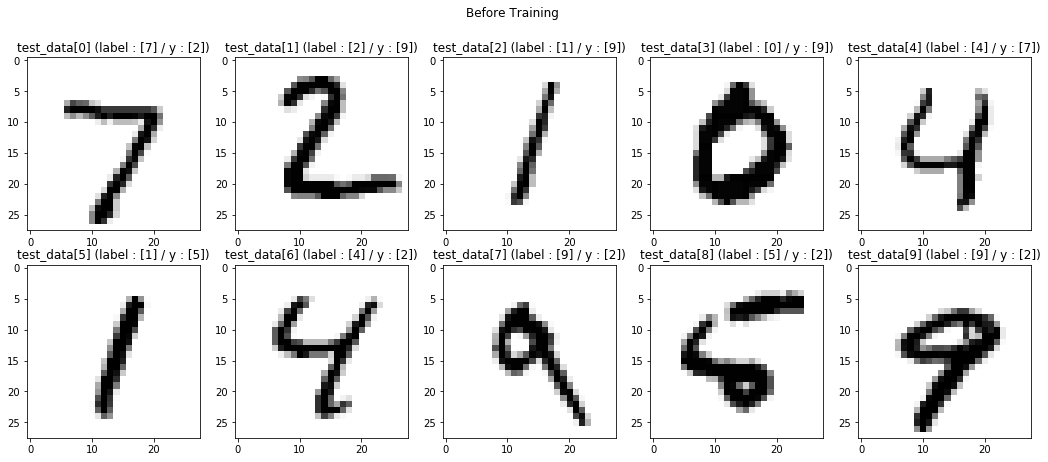

In [12]:
arr_epoch = []
arr_accu = []     # 기록 남겨보기 위함

# 학습 (Training)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_data_idx = np.arange(train_data_size[0])  # 실제 학습에 사용하기 위한 준비들


y_out = sess.run(hypothesis, feed_dict={x_ph: test_data})
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("Before Training", test_data, test_labels, y_max)

accu = Accuracy(y_out,test_labels)
arr_epoch.append(0)
arr_accu.append(accu)
# 사실 여기까지는 실제 트레이닝 하기 전임. 그 다음 탭부터가 트레이닝 시작!

> ### 학습 (Training)

In [13]:
%%time
for epoch_idx in range(1, N_epoch+1):
    np.random.shuffle(train_data_idx)   # 1 epoch를 마치고, 다시 mini-batch를 바꿔 묶는(?) 과정
    for batch_idx in range(batch_count):  # mini-batch size 단위로 다시 묶는 과정!
        
        # feeding을 위해 섞기
        batch_data = np.array([train_data[train_data_idx[batch_idx * batch_size + idx]] for idx in range(batch_size)])
        batch_labels = np.array([train_labels[train_data_idx[batch_idx * batch_size + idx]] for idx in range(batch_size)])

        sess.run(train, feed_dict={x_ph: batch_data, labels_ph: batch_labels})
        
    if epoch_idx%1 == 0:
        y_out = sess.run(hypothesis, feed_dict={x_ph: test_data})
        accu = Accuracy(y_out,test_labels)
        print("[{:>5}] accuracy = {:>10.4}".format(epoch_idx,accu))
        arr_epoch.append(epoch_idx)
        arr_accu.append(accu)

[    1] accuracy =     0.1234
[    2] accuracy =     0.1392
[    3] accuracy =     0.1627
[    4] accuracy =     0.1877
[    5] accuracy =     0.2159
[    6] accuracy =     0.2421
[    7] accuracy =      0.265
[    8] accuracy =     0.2889
[    9] accuracy =     0.3117
[   10] accuracy =     0.3351
[   11] accuracy =     0.3549
[   12] accuracy =     0.3757
[   13] accuracy =     0.3954
[   14] accuracy =     0.4146
[   15] accuracy =     0.4312
[   16] accuracy =     0.4447
[   17] accuracy =     0.4593
[   18] accuracy =     0.4732
[   19] accuracy =      0.487
[   20] accuracy =     0.4978
[   21] accuracy =     0.5093
[   22] accuracy =     0.5188
[   23] accuracy =     0.5302
[   24] accuracy =     0.5385
[   25] accuracy =     0.5477
[   26] accuracy =     0.5562
[   27] accuracy =     0.5648
[   28] accuracy =     0.5738
[   29] accuracy =     0.5803
[   30] accuracy =      0.586
[   31] accuracy =     0.5933
[   32] accuracy =     0.5999
[   33] accuracy =     0.6068
[   34] ac

> ### Ploting : Cost/Training Count

(0, 1.1)

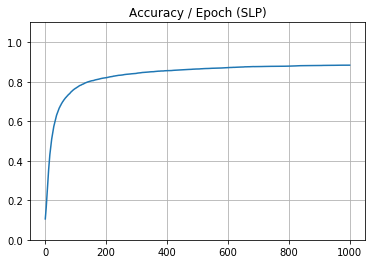

In [14]:
# Plot : Accuracy / Epoch
fig_accu, ax_accu = plt.subplots()
ax_accu.plot(arr_epoch, arr_accu)
ax_accu.set_title("Accuracy / Epoch (SLP)")
ax_accu.grid(True)
ax_accu.set_ylim(0,1.1)

> ### Training 이후

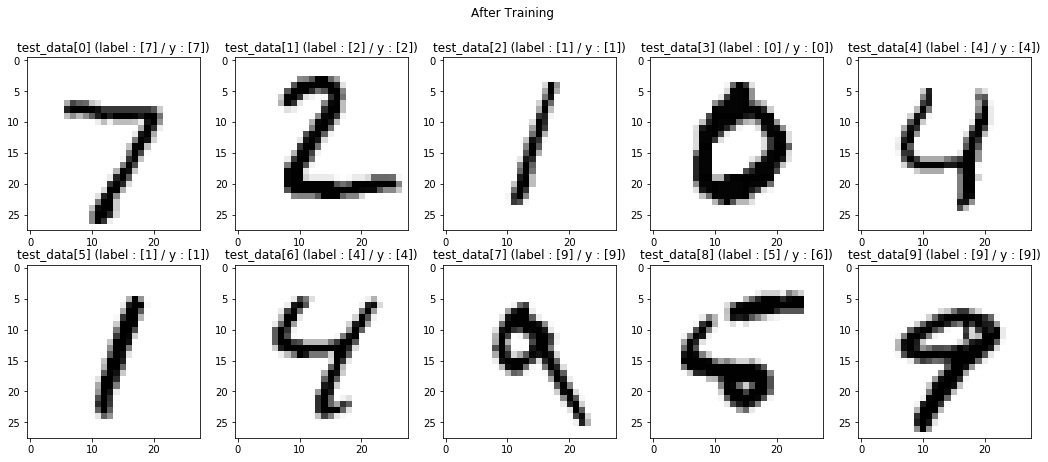

In [15]:
y_out = sess.run(hypothesis, feed_dict={x_ph: test_data})
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("After Training", test_data, test_labels, y_max)